In [1]:
import sys
sys.path.append("/Colorization/src")  # Append path to src
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from networks.dataset import load_dataset, get_dataset_prior_probs, ColorQuantization, PriorFactor
from networks.models import get_model
from networks.losses import get_loss_func
from networks.metrics import AUC, RebalancedAUC

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-29qxd7ek because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
root = '/Colorization/data/train2017'
annFile = '/Colorization/data/annotations/instances_train2017.json'
batch_size = 64
train_dataset = load_dataset(root, annFile, batch_size)

loading annotations into memory...
Done (t=9.69s)
creating index...
index created!


In [3]:
val_root = '/Colorization/data/val2017'
val_annFile = '/Colorization/data/annotations/instances_val2017.json'
val_dataset = load_dataset(val_root, val_annFile, batch_size)

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


In [4]:
import torch
pytorch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
model_str = 'eccv16_pretrained'
#model_str = 'eccv16'
model = get_model(model_str).to(pytorch_device)

loss_func_str = 'MSELoss_Vibrant'
color_vivid_gamma = 2.0
loss_func = get_loss_func(loss_func_str, None, color_vivid_gamma)

optimizer = torch.optim.Adam(model.parameters(),
                             lr=3*1e-5,
                             betas=(0.9,0.99),
                             weight_decay=1e-3)

In [12]:
model.name, len(train_dataset), len(val_dataset)

('eccv16_pretrained', 1849, 79)

In [7]:
root = '/Colorization/data/train2017'
annFile = '/Colorization/data/annotations/instances_train2017.json'
batch_size = 16
ab_gamut_filepath = '/Colorization/data/pts_in_hull.npy'
pytorch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

prior_probs = get_dataset_prior_probs(root, annFile, batch_size,
                                      ab_gamut_filepath, pytorch_device)
torch.cuda.empty_cache()

Found existing prior probs, won't regenerate it


In [8]:
color_quant = ColorQuantization(1, 5, ab_gamut_filepath)

In [13]:
## Eval metric
auc_metric = RebalancedAUC(prior_probs, color_quant, step_size = 1.0,
                           device="cpu")

model = model.eval()
with torch.no_grad():
    for i, (img_l, y) in enumerate(tqdm(val_dataset)):
        img_l = img_l.to(pytorch_device)
        y = y.to(pytorch_device)
        y_pred = model(img_l)
    #     print(y_pred.shape, y.shape)
        loss = loss_func(y_pred, y)
        #loss = loss_func(model.normalize_ab(y_pred), model.normalize_ab(y))
        #print(i, loss)

    #     print(np.max(y_pred.cpu().detach().numpy()), np.min(y_pred.cpu().detach().numpy()))
    #     diff = y_pred.cpu() - y.cpu()
    #     print(diff.detach().numpy().shape)
    #     diff = np.linalg.norm(diff.detach().numpy(), axis=1)
    #     print(diff.shape)
    #     diff_torch = torch.norm(y_pred-y, dim=1)
    #     print(diff_torch.shape)
    #     np.testing.assert_allclose(diff_torch.cpu().detach().numpy(), diff)
    #     print(np.max(diff), np.min(diff))
    #     print('cnt: ', np.count_nonzero(diff <= 150))
    #     loss = np.sum(diff) / 2 / img_l.shape[0]
    #     print(loss)

    #     diff = y.cpu() - y.cpu()
    #     print(diff.detach().numpy().shape)
    #     diff = np.linalg.norm(diff.detach().numpy(), axis=1) ** 2
    #     print(diff.shape)
    #     print(np.max(diff), np.min(diff))
    #     print('cnt: ', np.count_nonzero(diff <= 0)/ np.prod(diff.shape))
    #     loss = np.sum(diff) / 2 / img_l.shape[0]
    #     print(loss)

        auc_metric.reset()
        auc_metric.update((y_pred, y))
    #     roc_auc_metric.reset()
    #     roc_auc_metric.update((y_pred.reshape(-1), y.reshape(-1)))
    #     print(roc_auc_metric.compute())
        if i == 5:
            break

print(auc_metric.compute())

  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
  6%|▋         | 5/79 [03:30<52:01, 42.18s/it]

tensor(0.5455)


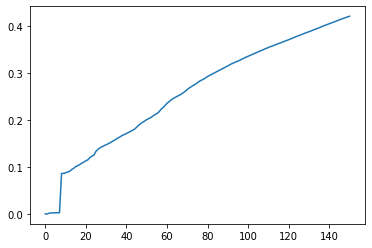

In [10]:
## RebalancedAUC from scratch
plt.plot(auc_metric.pos_cnt / auc_metric.tot_cnt)
# 0.2579

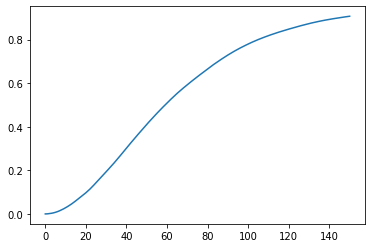

In [14]:
## RebalancedAUC pretrained
plt.plot(auc_metric.pos_cnt / auc_metric.tot_cnt)
# 

In [10]:
weights = pf.forward(color_quant.encode_1hot(y.cpu().numpy()))
weights.shape, weights.max(), weights.min()

((16, 1, 256, 256), 97.325005, 0.014699753)

torch.Size([16, 2, 256, 256]) torch.Size([16, 2, 256, 256])
Normal dist:  tensor(89.1384, grad_fn=<MaxBackward1>) tensor(0.0043, grad_fn=<MinBackward1>)
tensor(7270.2266, grad_fn=<MaxBackward1>) tensor(6.3826e-05, grad_fn=<MinBackward1>)
<class 'torch.Tensor'>
torch.Size([151])
torch.Size([1, 1, 1, 151]) torch.Size([16, 256, 256, 1])
torch.Size([16, 256, 256, 151])
tensor([      0,  652713,  726385,  779161,  826874,  856273,  876434,  889218,
         897908,  904720,  910739,  917619,  924527,  931337,  938023,  944814,
         951970,  958937,  964109,  967927,  970878,  973335,  975606,  977656,
         979561,  981245,  983117,  985127,  987033,  988737,  990357,  991940,
         993600,  995103,  996530,  998037,  999474, 1000818, 1002043, 1003205,
        1004455, 1005659, 1006923, 1008419, 1009694, 1010686, 1011480, 1012182,
        1012863, 1013509, 1014203, 1014853, 1015533, 1016231, 1016886, 1017500,
        1018098, 1018620, 1019104, 1019562, 1020047, 1020509, 1020986, 1

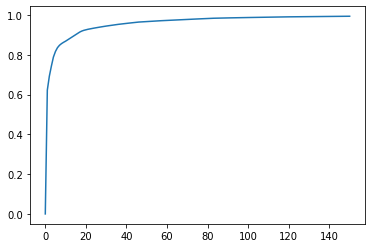

In [11]:
## AUC
print(y_pred.shape, y.shape)

diff = y_pred.cpu() - y.cpu()
#diff = y.cpu() - y.cpu()
dist = torch.norm(diff, dim=1)
print('Normal dist: ', dist.max(), dist.min())

dist = torch.norm(diff, dim=1) * torch.Tensor(weights[:, 0, ...])
# dist = torch.norm(diff, dim=1) * torch.Tensor(weights_pred)
#dist = torch.norm(diff, dim=1) / (torch.Tensor(weights[:, 0, ...]))

#dist = (150-torch.norm(diff, dim=1)) * torch.Tensor(prior_probs[inds][:, 0, ...])

print(dist.max(), dist.min())

#dist /= dist.max() * 150
#print(dist.max(), dist.min())

step = 1.0
thresholds = torch.arange(0, 150+step, step=step)
print(type(thresholds))
print(thresholds.shape)
print(thresholds[None,None,None,...].shape, dist[...,None].shape)

print(torch.le(dist[...,None], thresholds[None,None,None,...]).shape)

pos_cnt = torch.sum(torch.le(dist[...,None], thresholds[None,None,None,...]), dim=(0,1,2))
tot_cnt = torch.numel(dist)
print(pos_cnt, tot_cnt)
print(torch.sum(pos_cnt / tot_cnt) / torch.numel(pos_cnt))

plt.plot(pos_cnt / tot_cnt)

torch.Size([16, 2, 256, 256]) torch.Size([16, 2, 256, 256])
Normal dist:  tensor(99.2936, grad_fn=<MaxBackward1>) tensor(0.0700, grad_fn=<MinBackward1>)
tensor(6291.1841, grad_fn=<MaxBackward1>) tensor(0.0010, grad_fn=<MinBackward1>)
<class 'torch.Tensor'>
torch.Size([151])
torch.Size([1, 1, 1, 151]) torch.Size([16, 256, 256, 1])
torch.Size([16, 256, 256, 151])
tensor([      0,  621772,  684284,  744697,  761393,  770258,  790870,  827538,
         849705,  863153,  871821,  881767,  891733,  900384,  906212,  910248,
         912997,  915504,  917437,  919788,  921838,  923848,  926554,  930336,
         935337,  942272,  947890,  951800,  954796,  957425,  959941,  962226,
         965282,  968612,  970388,  971226,  971695,  971956,  972179,  972343,
         972556,  972984,  973585,  974329,  975337,  976691,  978356,  980187,
         982030,  983768,  985440,  986379,  987120,  987793,  988593,  989534,
         990484,  991638,  992763,  993882,  994945,  995985,  997043,  9980

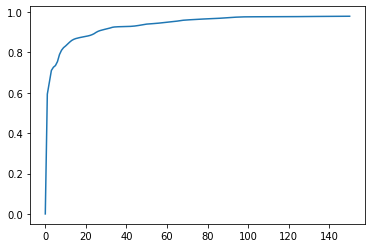

In [15]:
## AUC scratch
print(y_pred.shape, y.shape)

diff = y_pred.cpu() - y.cpu()
#diff = y.cpu() - y.cpu()
dist = torch.norm(diff, dim=1)
print('Normal dist: ', dist.max(), dist.min())

dist = torch.norm(diff, dim=1) * torch.Tensor(weights[:, 0, ...])
# dist = torch.norm(diff, dim=1) * torch.Tensor(weights_pred)
#dist = torch.norm(diff, dim=1) / (torch.Tensor(weights[:, 0, ...]))

#dist = (150-torch.norm(diff, dim=1)) * torch.Tensor(prior_probs[inds][:, 0, ...])

print(dist.max(), dist.min())

#dist /= dist.max() * 150
#print(dist.max(), dist.min())

step = 1.0
thresholds = torch.arange(0, 150+step, step=step)
print(type(thresholds))
print(thresholds.shape)
print(thresholds[None,None,None,...].shape, dist[...,None].shape)

print(torch.le(dist[...,None], thresholds[None,None,None,...]).shape)

pos_cnt = torch.sum(torch.le(dist[...,None], thresholds[None,None,None,...]), dim=(0,1,2))
tot_cnt = torch.numel(dist)
print(pos_cnt, tot_cnt)
print(torch.sum(pos_cnt / tot_cnt) / torch.numel(pos_cnt))

plt.plot(pos_cnt / tot_cnt)

## Debugging

In [179]:
import sys
sys.path.append("/Colorization/src")  # Append path to src
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from networks.dataset import load_dataset, get_dataset_prior_probs
from networks.models import get_model
from networks.losses import get_loss_func
from networks.metrics import AUC

In [9]:
root = '/Colorization/data/train2017'
annFile = '/Colorization/data/annotations/instances_train2017.json'
batch_size = 16
ab_gamut_filepath = '/Colorization/data/pts_in_hull.npy'
pytorch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

prior_probs = get_dataset_prior_probs(root, annFile, batch_size,
                                      ab_gamut_filepath, pytorch_device)
torch.cuda.empty_cache()

Found existing prior probs, won't regenerate it


In [315]:
## Eval metric
auc_metric = AUC(step_size = 1.0,
                           device="cpu")

model = model.eval()
with torch.no_grad():
    for i, (img_l, y) in enumerate(tqdm(val_dataset)):
        img_l = img_l.to(pytorch_device)
        y = y.to(pytorch_device)
        y_pred = model(img_l)
    #     print(y_pred.shape, y.shape)
        loss = loss_func(y_pred, y)
        #loss = loss_func(model.normalize_ab(y_pred), model.normalize_ab(y))
        #print(i, loss)

    #     print(np.max(y_pred.cpu().detach().numpy()), np.min(y_pred.cpu().detach().numpy()))
    #     diff = y_pred.cpu() - y.cpu()
    #     print(diff.detach().numpy().shape)
    #     diff = np.linalg.norm(diff.detach().numpy(), axis=1)
    #     print(diff.shape)
    #     diff_torch = torch.norm(y_pred-y, dim=1)
    #     print(diff_torch.shape)
    #     np.testing.assert_allclose(diff_torch.cpu().detach().numpy(), diff)
    #     print(np.max(diff), np.min(diff))
    #     print('cnt: ', np.count_nonzero(diff <= 150))
    #     loss = np.sum(diff) / 2 / img_l.shape[0]
    #     print(loss)

    #     diff = y.cpu() - y.cpu()
    #     print(diff.detach().numpy().shape)
    #     diff = np.linalg.norm(diff.detach().numpy(), axis=1) ** 2
    #     print(diff.shape)
    #     print(np.max(diff), np.min(diff))
    #     print('cnt: ', np.count_nonzero(diff <= 0)/ np.prod(diff.shape))
    #     loss = np.sum(diff) / 2 / img_l.shape[0]
    #     print(loss)

        auc_metric.reset()
        auc_metric.update((y_pred, y))
    #     roc_auc_metric.reset()
    #     roc_auc_metric.update((y_pred.reshape(-1), y.reshape(-1)))
    #     print(roc_auc_metric.compute())
        if i == 0:
            break

print(auc_metric.compute())

  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
  0%|          | 0/79 [00:03<?, ?it/s]

tensor(0.9028)


In [72]:
## AUC
print(y_pred.shape, y.shape)

diff = y_pred.cpu() - y.cpu()
dist = torch.norm(diff, dim=1)

step = 1.0
thresholds = torch.arange(0, 150+step, step=step)
print(type(thresholds))
print(thresholds.shape)
print(thresholds[None,None,None,...].shape, dist[...,None].shape)

pos_cnt = torch.sum(torch.le(dist[...,None], thresholds[None,None,None,...]), dim=(0,1,2))
tot_cnt = torch.numel(dist)
print(pos_cnt, tot_cnt)
torch.sum(pos_cnt / tot_cnt) / torch.numel(pos_cnt)

torch.Size([16, 2, 256, 256]) torch.Size([16, 2, 256, 256])
<class 'torch.Tensor'>
torch.Size([151])
torch.Size([1, 1, 1, 151]) torch.Size([16, 256, 256, 1])
tensor([      0,  173532,  232595,  299043,  355105,  396441,  429464,  462477,
         494401,  520777,  544423,  564623,  583766,  602481,  619624,  635068,
         653826,  676147,  695187,  708931,  721016,  733764,  747234,  762772,
         780408,  798135,  813594,  827767,  841860,  855562,  869522,  881657,
         891943,  900927,  909434,  917776,  926352,  934665,  942266,  948602,
         954051,  959067,  964043,  971111,  977266,  982414,  987180,  991691,
         996881, 1000631, 1004238, 1007842, 1011093, 1013809, 1016264, 1018564,
        1020841, 1022952, 1024940, 1026835, 1028452, 1029893, 1031310, 1033348,
        1035634, 1037272, 1038704, 1040397, 1042085, 1043603, 1044569, 1045319,
        1045952, 1046440, 1046899, 1047332, 1047701, 1047933, 1048029, 1048070,
        1048101, 1048135, 1048169, 1048209

tensor(0.8961)

In [11]:
def knn(ref, query, k: int = 10):
    # query: [N, 2]. ref: [K, 2]
    # query[:,None,:] - ref: [N, K, 2]
    dists = torch.norm(query[:,None,:] - ref, dim=-1)  # [N, K]
    #dists, inds = torch.sort(dists, dim=-1)
    dists, inds = torch.topk(dists, k, dim=-1, largest=False, sorted=False)
    return dists, inds

In [12]:
## RebalancedAUC
ab_grids = np.load('/Colorization/data/pts_in_hull.npy')
dists, inds = knn(torch.Tensor(ab_grids),
                  torch.moveaxis(y.cpu(), 1, -1).reshape(-1,2),
                  1)
print(dists, inds)

tensor([[6.2686],
        [6.1089],
        [5.4987],
        ...,
        [3.4822],
        [4.0059],
        [4.4669]]) tensor([[140],
        [121],
        [121],
        ...,
        [120],
        [120],
        [120]])


In [251]:
## RebalancedAUC
ab_grids = np.load('/Colorization/data/pts_in_hull.npy')
dists_pred, inds_pred = knn(torch.Tensor(ab_grids),
                  torch.moveaxis(y_pred.cpu(), 1, -1).reshape(-1,2),
                  1)
print(dists_pred, inds_pred)

tensor([[0.1999],
        [0.1999],
        [0.1999],
        ...,
        [0.1996],
        [0.1996],
        [0.1996]]) tensor([[120],
        [120],
        [120],
        ...,
        [120],
        [120],
        [120]])


In [252]:
inds_pred = inds_pred.reshape(
    np.array(torch.moveaxis(y.cpu(), 1, -1).shape[:-1]).tolist())
print(inds_pred.shape)

torch.Size([64, 256, 256])


In [261]:
## RebalancedAUC
ab_grids = np.load('/Colorization/data/pts_in_hull.npy')
dists_pred, inds_pred_pretrained = knn(torch.Tensor(ab_grids),
                  torch.moveaxis(y_pred.cpu(), 1, -1).reshape(-1,2),
                  1)
print(dists_pred, inds_pred_pretrained)

inds_pred_pretrained = inds_pred_pretrained.reshape(
    np.array(torch.moveaxis(y.cpu(), 1, -1).shape[:-1]).tolist())
print(inds_pred_pretrained.shape)

tensor([[4.0227],
        [4.0227],
        [4.0687],
        ...,
        [3.6781],
        [3.3508],
        [3.3508]]) tensor([[121],
        [121],
        [121],
        ...,
        [122],
        [122],
        [122]])
torch.Size([64, 256, 256])


In [13]:
dists.shape, inds.shape

(torch.Size([1048576, 1]), torch.Size([1048576, 1]))

In [13]:
inds = inds.reshape(
    np.array(torch.moveaxis(y.cpu(), 1, -1).shape[:-1]).tolist() + [inds.shape[-1]])
print(inds.shape)

torch.Size([64, 256, 256, 1])


In [14]:
inds = torch.moveaxis(inds, -1, 1)
print(inds.shape)

torch.Size([64, 1, 256, 256])


In [308]:
prior_probs2 = (prior_probs - prior_probs.min()) / (prior_probs.max() - prior_probs.min()) * 20 + 1
prior_probs2.shape, prior_probs2.min(), prior_probs2.max()

((313,), 1.0, 21.0)

In [282]:
prior_probs.shape, prior_probs.min(), prior_probs.max()

((313,), 1.6372408e-09, 0.21734297)

In [16]:
inds[10, 0, 200, 150], ab_grids[inds[10, 0, 200, 160]], y[10, :, 200, 160], prior_probs[120]

(tensor(119),
 array([  0, -10]),
 tensor([  0.8204, -13.2110], device='cuda:0'),
 0.21734297)

In [271]:
prior_factor = 1./prior_probs
prior_factor /= np.sum(prior_probs * prior_factor)
#prior_factor -= (prior_factor.min()-1)
#prior_factor /= (prior_factor.min())
#prior_factor = (prior_factor - prior_factor.min()) / (prior_factor.max()-prior_factor.min()) * 149 + 1.0
np.sum(prior_probs * prior_factor), prior_factor.min(), prior_factor.max()

(1.0, 0.014699753, 1951385.5)

In [140]:
implied_prior = prior_probs*prior_factor
implied_prior.shape, implied_prior.max(), implied_prior.min()

((313,), 0.217343, 0.21734296)

In [141]:
prior_probs[inds].shape

(64, 1, 256, 256)

In [241]:
weights = prior_probs[inds]
#weights = (weights - weights.min(axis=0)) / (weights.max(axis=0) - weights.min(axis=0)) * 149 + 1
#weights /= weights.min(axis=0)
#weights[weights < 1] = 1
weights.shape, weights.max(), weights.min()

((64, 1, 256, 256), 1.0, 1.0)

In [21]:
weights[10, :, 200, 150], prior_factor[0]

(array([0.04137326], dtype=float32), 198749.83)

In [22]:
dist.shape

NameError: name 'dist' is not defined

In [317]:
weights_pred = prior_probs2[inds_pred]
weights_pred.shape, weights_pred.max(), weights_pred.min()

((64, 256, 256), 21.0, 21.0)

In [310]:
weights_pred_pretrained = prior_probs2[inds_pred_pretrained]
# weights_pred_pretrained = (weights_pred_pretrained - weights_pred_pretrained.min(axis=0)) \
#     / (weights_pred_pretrained.max(axis=0) - weights_pred_pretrained.min(axis=0)) * 149 + 1
weights_pred_pretrained.shape, weights_pred_pretrained.max(), weights_pred_pretrained.min()

((64, 256, 256), 21.0, 1.0150025)

In [ ]:
np.sum(weights_pred)

In [80]:
weights_pred

array([[[0.01469975, 0.01469975, 0.01469975, ..., 0.01469975,
         0.01469975, 0.01469975],
        [0.01469975, 0.01469975, 0.01469975, ..., 0.01469975,
         0.01469975, 0.01469975],
        [0.01469975, 0.01469975, 0.01469975, ..., 0.01469975,
         0.01469975, 0.01469975],
        ...,
        [0.01469975, 0.01469975, 0.01469975, ..., 0.01469975,
         0.01469975, 0.01469975],
        [0.01469975, 0.01469975, 0.01469975, ..., 0.01469975,
         0.01469975, 0.01469975],
        [0.01469975, 0.01469975, 0.01469975, ..., 0.01469975,
         0.01469975, 0.01469975]],

       [[0.01469975, 0.01469975, 0.01469975, ..., 0.01469975,
         0.01469975, 0.01469975],
        [0.01469975, 0.01469975, 0.01469975, ..., 0.01469975,
         0.01469975, 0.01469975],
        [0.01469975, 0.01469975, 0.01469975, ..., 0.01469975,
         0.01469975, 0.01469975],
        ...,
        [0.01469975, 0.01469975, 0.01469975, ..., 0.01469975,
         0.01469975, 0.01469975],
        [0.0

In [105]:
weights

array([[[[0.5757749 , 0.5757749 , 0.5757749 , ..., 0.16769165,
          0.16769165, 0.16769165],
         [0.5757749 , 0.5757749 , 0.5757749 , ..., 0.16769165,
          0.16769165, 0.16769165],
         [0.5757749 , 0.5757749 , 0.5757749 , ..., 0.16769165,
          0.16769165, 0.16769165],
         ...,
         [0.32328326, 0.5455949 , 0.32328326, ..., 0.01469975,
          0.01469975, 0.01469975],
         [0.08311431, 0.08311431, 0.02920701, ..., 0.31318608,
          0.06700978, 0.06700978],
         [0.08311431, 0.08311431, 0.08311431, ..., 1.1080196 ,
          1.1080196 , 1.1080196 ]]],


       [[[1.2569231 , 1.2569231 , 1.2569231 , ..., 0.6650914 ,
          0.6650914 , 0.29339182],
         [1.2638615 , 1.2638615 , 1.2569231 , ..., 0.6650914 ,
          0.6650914 , 0.6650914 ],
         [1.2638615 , 1.2638615 , 1.2638615 , ..., 0.6171696 ,
          0.6650914 , 0.29339182],
         ...,
         [0.08311431, 0.08311431, 0.08311431, ..., 0.06700978,
          0.06700978, 0

eccv16 torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
tensor(0.3144, device='cuda:0') tensor(0.1918, device='cuda:0')
Normal dist:  tensor(102.8277) tensor(0.1710)
tensor(2159.3826) tensor(3.5904)
<class 'torch.Tensor'>
torch.Size([151])
torch.Size([1, 1, 1, 151]) torch.Size([64, 256, 256, 1])
torch.Size([64, 256, 256, 151])
tensor([      0,       0,       0,       0,    1163,    4539,    7556,   11804,
         586712,  595187,  597596,  600475,  603896,  611890,  619816,  633974,
         639779,  654528,  676210,  692549,  699192,  707467,  721769,  734515,
         741786,  750003,  757342,  771859,  796751,  808358,  833330,  843463,
         853258,  861939,  870242,  878163,  888061,  897539,  908696,  920471,
         937067,  947293,  957537,  966051,  974172,  983214,  991318,  999774,
        1009159, 1021550, 1036851, 1052462, 1064628, 1078181, 1087702, 1098087,
        1107755, 1118887, 1128720, 1141366, 1158961, 1175493, 1190510, 1201746,
        1212985, 122

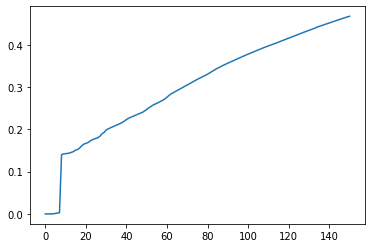

In [316]:
## AUC
print(model.name, y_pred.shape, y.shape)

diff = y_pred.cpu() - y.cpu()
print(y_pred.max(), y_pred.min())
#diff = y.cpu() - y.cpu()
dist = torch.norm(diff, dim=1)
print('Normal dist: ', dist.max(), dist.min())

#dist = torch.norm(diff, dim=1) * torch.Tensor(weights[:, 0, ...])
dist = torch.norm(diff, dim=1) * torch.Tensor(weights_pred)
#dist = torch.norm(diff, dim=1) / (torch.Tensor(weights[:, 0, ...]))

#dist = (150-torch.norm(diff, dim=1)) * torch.Tensor(prior_probs[inds][:, 0, ...])

print(dist.max(), dist.min())

#dist /= dist.max() * 150
#print(dist.max(), dist.min())

step = 1.0
thresholds = torch.arange(0, 150+step, step=step)
print(type(thresholds))
print(thresholds.shape)
print(thresholds[None,None,None,...].shape, dist[...,None].shape)

print(torch.le(dist[...,None], thresholds[None,None,None,...]).shape)

pos_cnt = torch.sum(torch.le(dist[...,None], thresholds[None,None,None,...]), dim=(0,1,2))
tot_cnt = torch.numel(dist)
print(pos_cnt, tot_cnt)
print(torch.sum(pos_cnt / tot_cnt) / torch.numel(pos_cnt))

plt.plot(pos_cnt / tot_cnt)

eccv16 torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
tensor(0.3144, device='cuda:0') tensor(0.1918, device='cuda:0')
Normal dist:  tensor(102.8277) tensor(0.1710)
tensor(1877.2498) tensor(0.2023)
<class 'torch.Tensor'>
torch.Size([151])
torch.Size([1, 1, 1, 151]) torch.Size([64, 256, 256, 1])
torch.Size([64, 256, 256, 151])
tensor([      0,  162477,  366170,  456863,  495446,  572608,  613780,  657601,
         831258,  877679,  926923,  971799, 1020443, 1066719, 1116681, 1170530,
        1218013, 1268816, 1318969, 1367605, 1414275, 1458114, 1500885, 1541055,
        1575589, 1609952, 1644613, 1688683, 1736160, 1770972, 1815640, 1848286,
        1884936, 1917850, 1949373, 1981189, 2012868, 2043942, 2076486, 2108917,
        2142873, 2173490, 2204257, 2234833, 2265829, 2296126, 2326492, 2355015,
        2383243, 2411960, 2442790, 2471217, 2497704, 2522385, 2547582, 2572469,
        2600554, 2625650, 2650713, 2674604, 2702090, 2729700, 2755620, 2779912,
        2803530, 282

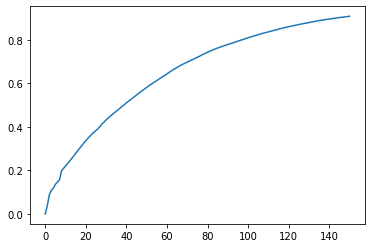

In [319]:
## AUC scratch
print(model.name, y_pred.shape, y.shape)

diff = y_pred.cpu() - y.cpu()
print(y_pred.max(), y_pred.min())
#diff = y.cpu() - y.cpu()
dist = torch.norm(diff, dim=1)
print('Normal dist: ', dist.max(), dist.min())

#dist = torch.norm(diff, dim=1) * torch.Tensor(weights[:, 0, ...])
dist = torch.norm(diff, dim=1) * torch.Tensor(weights_pred_pretrained)
#dist = torch.norm(diff, dim=1) / (torch.Tensor(weights[:, 0, ...]))

#dist = (150-torch.norm(diff, dim=1)) * torch.Tensor(prior_probs[inds][:, 0, ...])

print(dist.max(), dist.min())

#dist /= dist.max() * 150
#print(dist.max(), dist.min())

step = 1.0
thresholds = torch.arange(0, 150+step, step=step)
print(type(thresholds))
print(thresholds.shape)
print(thresholds[None,None,None,...].shape, dist[...,None].shape)

print(torch.le(dist[...,None], thresholds[None,None,None,...]).shape)

pos_cnt = torch.sum(torch.le(dist[...,None], thresholds[None,None,None,...]), dim=(0,1,2))
tot_cnt = torch.numel(dist)
print(pos_cnt, tot_cnt)
print(torch.sum(pos_cnt / tot_cnt) / torch.numel(pos_cnt))

plt.plot(pos_cnt / tot_cnt)

In [111]:
prior_probs[inds].min()

3.2827003e-05

## No weighting

torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
Normal dist:  tensor(102.3327) tensor(0.0679)
tensor(102.3327) tensor(0.0679)
<class 'torch.Tensor'>
torch.Size([151])
torch.Size([1, 1, 1, 151]) torch.Size([64, 256, 256, 1])
torch.Size([64, 256, 256, 151])
tensor([      0,  726085,  963402, 1195531, 1422628, 1621856, 1784008, 1931373,
        2061631, 2172408, 2266395, 2356664, 2446095, 2524130, 2597530, 2670418,
        2745891, 2826175, 2905620, 2983633, 3057791, 3123794, 3184603, 3239514,
        3291784, 3342985, 3388677, 3428930, 3466603, 3501999, 3537774, 3571874,
        3605143, 3637761, 3669975, 3704021, 3737100, 3767689, 3792537, 3815639,
        3841184, 3873842, 3901726, 3925503, 3946494, 3962261, 3976110, 3988813,
        4002148, 4014492, 4026143, 4037609, 4048820, 4058757, 4068055, 4077307,
        4086248, 4094717, 4102700, 4110452, 4118270, 4125691, 4131799, 4137185,
        4142342, 4146630, 4150334, 4154044, 4157807, 4161529, 4164457, 4166978,
        4169

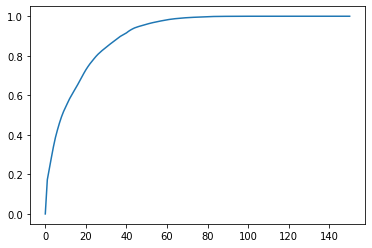

In [87]:
## AUC scratch
print(y_pred.shape, y.shape)

diff = y_pred.cpu() - y.cpu()
#diff = y.cpu() - y.cpu()
dist = torch.norm(diff, dim=1)
print('Normal dist: ', dist.max(), dist.min())

dist = torch.norm(diff, dim=1)
# dist = torch.norm(diff, dim=1) * torch.Tensor(weights_pred)
#dist = torch.norm(diff, dim=1) / (torch.Tensor(weights[:, 0, ...]))

#dist = (150-torch.norm(diff, dim=1)) * torch.Tensor(prior_probs[inds][:, 0, ...])

print(dist.max(), dist.min())

#dist /= dist.max() * 150
#print(dist.max(), dist.min())

step = 1.0
thresholds = torch.arange(0, 150+step, step=step)
print(type(thresholds))
print(thresholds.shape)
print(thresholds[None,None,None,...].shape, dist[...,None].shape)

print(torch.le(dist[...,None], thresholds[None,None,None,...]).shape)

pos_cnt = torch.sum(torch.le(dist[...,None], thresholds[None,None,None,...]), dim=(0,1,2))
tot_cnt = torch.numel(dist)
print(pos_cnt, tot_cnt)
print(torch.sum(pos_cnt / tot_cnt) / torch.numel(pos_cnt))

plt.plot(pos_cnt / tot_cnt)

torch.Size([64, 2, 256, 256]) torch.Size([64, 2, 256, 256])
Normal dist:  tensor(113.9902) tensor(0.0038)
tensor(113.9902) tensor(0.0038)
<class 'torch.Tensor'>
torch.Size([151])
torch.Size([1, 1, 1, 151]) torch.Size([64, 256, 256, 1])
torch.Size([64, 256, 256, 151])
tensor([      0,   63030,  170796,  304280,  461445,  631558,  807792,  987092,
        1169182, 1346033, 1520298, 1688023, 1846632, 1999393, 2144117, 2280689,
        2409853, 2532230, 2648118, 2760635, 2871974, 2982190, 3088097, 3187226,
        3278706, 3360493, 3432484, 3495281, 3553182, 3606509, 3656347, 3703985,
        3747956, 3786866, 3821576, 3853584, 3884993, 3916328, 3945749, 3972764,
        3998135, 4021382, 4042118, 4061337, 4078649, 4094299, 4108179, 4120410,
        4130835, 4139600, 4147378, 4154275, 4160127, 4164776, 4168403, 4171413,
        4173991, 4176329, 4178454, 4180300, 4181886, 4183375, 4184719, 4185946,
        4187047, 4188087, 4189011, 4189841, 4190494, 4191017, 4191412, 4191701,
        4191

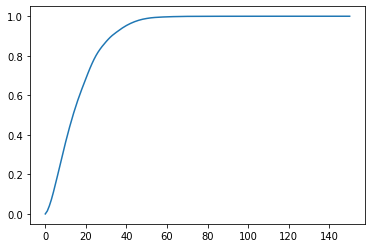

In [91]:
## AUC pretrained
print(y_pred.shape, y.shape)

diff = y_pred.cpu() - y.cpu()
#diff = y.cpu() - y.cpu()
dist = torch.norm(diff, dim=1)
print('Normal dist: ', dist.max(), dist.min())

dist = torch.norm(diff, dim=1)
# dist = torch.norm(diff, dim=1) * torch.Tensor(weights_pred)
#dist = torch.norm(diff, dim=1) / (torch.Tensor(weights[:, 0, ...]))

#dist = (150-torch.norm(diff, dim=1)) * torch.Tensor(prior_probs[inds][:, 0, ...])

print(dist.max(), dist.min())

#dist /= dist.max() * 150
#print(dist.max(), dist.min())

step = 1.0
thresholds = torch.arange(0, 150+step, step=step)
print(type(thresholds))
print(thresholds.shape)
print(thresholds[None,None,None,...].shape, dist[...,None].shape)

print(torch.le(dist[...,None], thresholds[None,None,None,...]).shape)

pos_cnt = torch.sum(torch.le(dist[...,None], thresholds[None,None,None,...]), dim=(0,1,2))
tot_cnt = torch.numel(dist)
print(pos_cnt, tot_cnt)
print(torch.sum(pos_cnt / tot_cnt) / torch.numel(pos_cnt))

plt.plot(pos_cnt / tot_cnt)